<a href="https://colab.research.google.com/github/17092003vamsi/guner/blob/main/SVM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class Distribution: Counter({0: 165, 1: 157, 2: 157, 5: 153, 3: 151, 4: 149})
Training Accuracy: 1.0000
Testing Accuracy: 0.9572


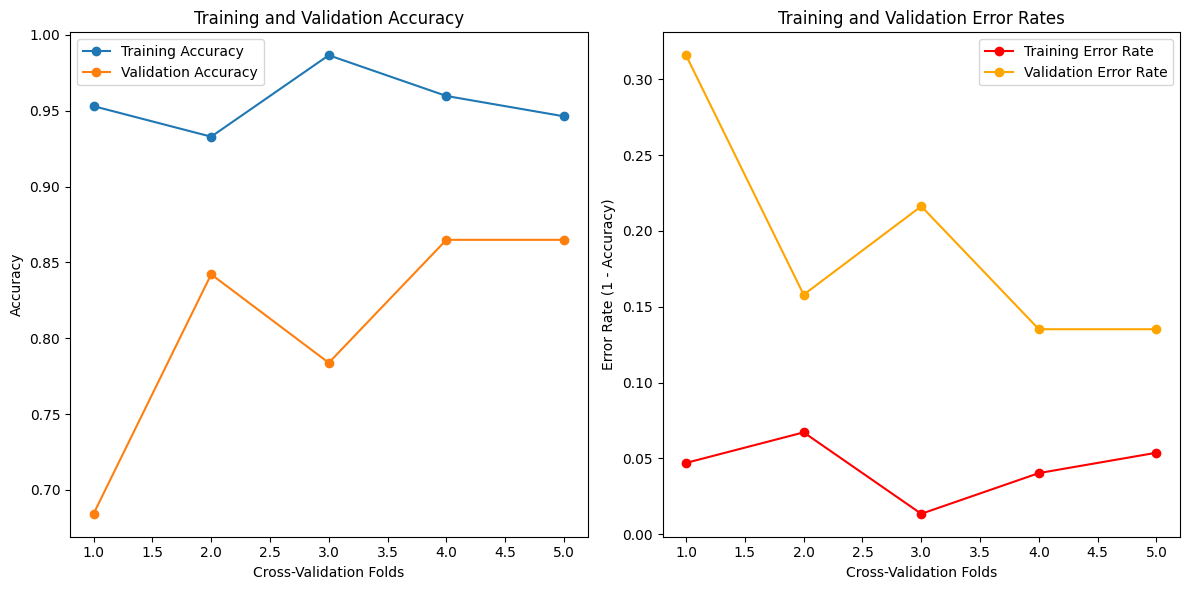

<Figure size 800x600 with 0 Axes>

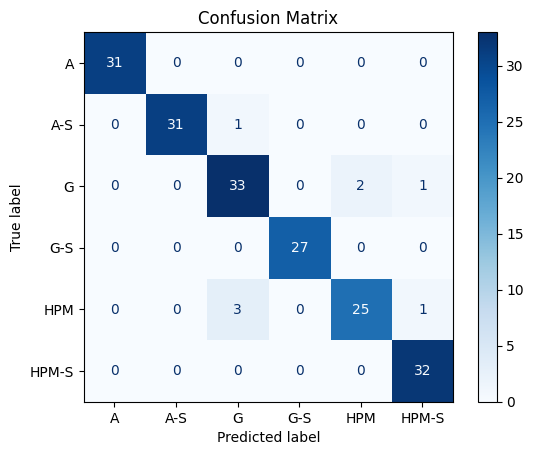

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        31
         A-S       1.00      0.97      0.98        32
           G       0.89      0.92      0.90        36
         G-S       1.00      1.00      1.00        27
         HPM       0.93      0.86      0.89        29
       HPM-S       0.94      1.00      0.97        32

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer # Import SimpleImputer for imputation
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

# Load the data
data = pd.read_csv('/content/project 2 sap.csv')

# Encode categorical features
type_encoder = LabelEncoder()
data['Type'] = type_encoder.fit_transform(data['Type'])

label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])

# Separate features and target
X = data.drop(columns=['Lable'])
y = data['Lable']

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_imputed = imputer.fit_transform(X) # Fit and transform the data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed) # Use imputed data for scaling

# Check for class distribution before splitting
from collections import Counter
class_distribution = Counter(y)
print("Class Distribution:", class_distribution)

# If any class has only 1 sample, you can't stratify
# Either remove those samples or adjust your splitting strategy
# For example, if class '2' has only 1 sample:
# data = data[data['Lable'] != 2]  # Remove samples of class '2'
# X = data.drop(columns=['Lable'])
# y = data['Lable']
# X_scaled = scaler.fit_transform(imputer.fit_transform(X)) # Recalculate X_scaled

# Or, you can remove the 'stratify' parameter if it's not crucial
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Since class 1 has only 1 sample, removing the 'stratify' parameter:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # Removed stratify=y

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Use StratifiedKFold for cross-validation to ensure class balance in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for training and validation accuracy and error rate
train_scores = cross_val_score(svm_model, X_train, y_train, cv=skf)  # Use skf for train
# Instead of using StratifiedKFold for the test set, use KFold, as StratifiedKFold might create folds with only one
val_scores = cross_val_score(svm_model, X_test, y_test, cv=skf)  # Use skf for test


train_error_rates = 1 - train_scores
val_error_rates = 1 - val_scores
folds = np.arange(1, len(train_scores) + 1)

# Plot training and validation accuracy and error rates
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(folds, train_scores, label='Training Accuracy', marker='o')
plt.plot(folds, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(folds, train_error_rates, label='Training Error Rate', marker='o', color='red')
plt.plot(folds, val_error_rates, label='Validation Error Rate', marker='o', color='orange')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.legend()
plt.title('Training and Validation Error Rates')

plt.tight_layout()
plt.show()

# Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Get the original labels using the label encoder
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
conf_matrix_display.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
# Get unique labels from y_test and y_pred_test
unique_labels = np.unique(np.concatenate((y_test, y_pred_test)))

# Get target names for the unique labels
target_names = label_encoder.classes_[unique_labels]

print(classification_report(y_test, y_pred_test, target_names=target_names))

# Initialize SHAP explainer for SVM
explainer = shap.KernelExplainer(svm_model.predict_proba, shap.kmeans(X_train, 10))

# Calculate SHAP values for test set
shap_values_test = explainer.shap_values(X_test)

# SHAP summary plot for test set
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_test, X_test, plot_type="bar", feature_names=X.columns)
plt.title("SHAP Feature Importance for Test Set")
plt.show()
